In [1304]:
%matplotlib inline

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.linear_model import Lasso, Ridge
from sklearn.preprocessing import LabelEncoder

import xgboost as xgb

sns.set_style('whitegrid')

import warnings
warnings.filterwarnings('ignore')

SEED = 23133

%run ../src/data/make_dataset.py
%run ../src/features/build_features.py
%run ../src/models/cross_validation.py
%run ../src/features/average_features.py

# Load Files

In [832]:
# contracts
contracts_new = pd.read_csv('../data/raw/Train_BG1IL20/Train/Contracts_New.csv')
contracts_end = pd.read_csv('../data/raw/Train_BG1IL20/Train/Contracts_End.csv')

# load contacts and resolutions
contacts   = pd.read_csv('../data/raw/Train_BG1IL20/Train/Contacts_Pre_2017.csv', parse_dates=['START.DATE', 'END.DATE'])
resolution = pd.read_csv('../data/raw/Train_BG1IL20/Train/Resolution_Pre_2017.csv', 
                                  encoding = 'ISO-8859-1', parse_dates=['Date', 'End_Date'])

# test data files
contacts_test   = pd.read_csv('../data/raw/Test_74k7qT9/Test/Contacts2017.csv', parse_dates=['Date'])
resolution_test = pd.read_csv('../data/raw/Test_74k7qT9/Test/Resolution2017.csv', parse_dates=['Date'])

# Contacts

In [833]:
contacts_df = get_contacts_df(contacts)

# Resolutions

In [834]:
resolution_df = get_resolutions_df(resolution)

# Subsample

In [ ]:
    ((contacts_df.dates >= '2011/01/01') & (contacts_df.dates <= '2011/03/31'))\
       | ((contacts_df.dates >= '2012/01/01') & (contacts_df.dates <= '2012/03/31'))\
       | ((contacts_df.dates >= '2013/01/01') & (contacts_df.dates <= '2013/03/31'))\
       contacts_df.dates >= '2014/01/01') & (contacts_df.dates <= '2014/03/31'))\
       

In [1242]:
mask = ((contacts_df.dates >= '2012/01/01') & (contacts_df.dates <= '2012/03/31'))\
       | ((contacts_df.dates >= '2013/01/01') & (contacts_df.dates <= '2013/03/31'))\
       | ((contacts_df.dates >= '2014/01/01') & (contacts_df.dates <= '2014/03/31'))\
       | ((contacts_df.dates >= '2015/01/01') & (contacts_df.dates <= '2015/03/31'))\
       | ((contacts_df.dates >= '2016/01/01') & (contacts_df.dates <= '2016/03/31') & (contacts_df.contact_types != 'Internal Management'))\
        
contacts_df_sub = contacts_df.loc[mask, :]

mask =   ((resolution_df.dates >= '2012/01/01') & (resolution_df.dates <= '2012/03/31'))\
       | ((resolution_df.dates >= '2013/01/01') & (resolution_df.dates <= '2013/03/31'))\
       | ((resolution_df.dates >= '2014/01/01') & (resolution_df.dates <= '2014/03/31'))\
       | ((resolution_df.dates >= '2015/01/01') & (resolution_df.dates <= '2015/03/31'))\
       | ((resolution_df.dates >= '2016/01/01') & (resolution_df.dates <= '2016/03/31'))\
        
resolution_df_sub = resolution_df.loc[mask, :]

# Contracts

In [781]:
contracts_new_df, contracts_end_df = modify_contracts(contracts_new, contracts_end)

KeyboardInterrupt: 

In [278]:
# get active contracts by day of year
active_contracts = get_active_contracts_by_day(contracts_new_df, contracts_end_df)

In [159]:
num_contracts_started = contracts_new_df.groupby('date')['NUMBER_OF_CONTRACTS'].sum()
num_contracts_ended   = contracts_end_df.groupby('date')['NUMBER_OF_CONTRACTS_ENDED'].sum()

# date range
date_range = pd.date_range(start='2005-11-25', end='2016-12-31')

num_contracts_started = num_contracts_started.reindex(date_range).fillna(0)
num_contracts_ended   = num_contracts_ended.reindex(date_range).fillna(0)

# total events
num_total_events = num_contracts_started + num_contracts_ended
num_total_events = num_total_events.reset_index()
num_total_events = num_total_events.rename(columns={0: 'total_events'})
num_total_events['index'] = pd.to_datetime(num_total_events['index'])

In [161]:
def find_contracts_3_months_back(total_events, dates):
    events = {}
    
    for date_ in dates:
        lookup_date   = pd.to_datetime(date_) + pd.DateOffset(-90)
        
        if date_ not in events:
            events[date_] = total_events.loc[total_events['index'] == lookup_date, 'total_events'].values[0]
        
    return events

In [162]:
_3_months_events         = find_contracts_3_months_back(num_total_events, contacts_df_sub.dates.values)
_3_months_back_contracts = contacts_df_sub.dates.map(_3_months_events)
contacts_df_sub          = contacts_df_sub.assign(_3_months_back_contracts=_3_months_back_contracts)

In [163]:
_3_months_events_test         = find_contracts_3_months_back(num_total_events, contacts_test.Date.values)
_3_months_back_contracts_test = contacts_test.Date.map(_3_months_events_test)
contacts_test                 = contacts_test.assign(_3_months_back_contracts=_3_months_back_contracts_test)

# Feature Engineering

In [1243]:
contacts_df_sub = contacts_df_sub.rename(columns={'dates': 'date', 'contact_types': 'contact_type'})
contacts_test   = contacts_test.rename(columns={'Date': 'date', 'CONTACT.TYPE': 'contact_type'})

contacts_df_sub, contacts_test = prepare_average_features(contacts_df, contacts_df_sub, contacts_test)

In [1305]:
data         = pd.concat((contacts_df_sub, contacts_test))
data['date'] = pd.to_datetime(data['date'])

dt = Dataset(data)

dt.add_week()\
  .add_month()\
  .add_year()\
  .add_dayofyear()\
  .add_weekday()\
  .add_isweekend()\
  .add_isspecialday()\
  .add_mean_num_contacts_by_week()\
  .add_median_num_contacts_by_type()\
  .add_mean_num_contacts_by_type_month()\
  .add_max_num_contacts_by_type_month()\
  .add_min_num_contacts_by_type_month()\
  .add_range_contacts_by_type_month()\
  .ohe_features(['contact_type'])

** Contracts Features **

In [166]:
_3_months_events         = find_contracts_3_months_back(num_total_events, resolution_df_sub.dates.values)
_3_months_back_contracts = resolution_df_sub.dates.map(_3_months_events)
resolution_df_sub        = resolution_df_sub.assign(_3_months_back_contracts=_3_months_back_contracts)

In [167]:
_3_months_events_test         = find_contracts_3_months_back(num_total_events, resolution_test.Date.values)
_3_months_back_contracts_test = resolution_test.Date.map(_3_months_events_test)
resolution_test               = resolution_test.assign(_3_months_back_contracts=_3_months_back_contracts_test)

** Resolution Features **

In [1269]:
resolution_df_sub = resolution_df_sub.rename(columns={'dates': 'date'})
resolution_test   = resolution_test.rename(columns={'Date': 'date', 'Category': 'categories', 'Subject': 'subjects'})

data = pd.concat((resolution_df_sub, resolution_test))
data['date'] = pd.to_datetime(data['date'])

dt_res = Dataset(data)

dt_res.add_week()\
  .add_month()\
  .add_year()\
  .add_dayofyear()\
  .add_weekday()\
  .add_isweekend()\
  .add_isspecialday()\
  .ohe_features(['categories', 'subjects'])

# Processing

In [1306]:
train = dt.dataset.iloc[:len(contacts_df_sub)]
test  = dt.dataset.iloc[len(contacts_df_sub):]

In [1307]:
train.columns

Index(['contact_type_Fax - Input', 'contact_type_Fax Acknowledgement - Input',
       'contact_type_Installation Report - Input',
       'contact_type_Internal Management', 'contact_type_Mail - Input',
       'contact_type_Mail - Recieved', 'contact_type_Tweet - Input',
       'contact_type_Visit', 'contact_type_Web - Input', 'Contacts', 'ID',
       'contact_type', 'date', 'num_contacts', 'quarter_mean', 'week', 'month',
       'year', 'day_of_year', 'weekday', 'is_weekend', 'isspecialday',
       'mean_contact_week', 'median_contact_type', 'mean_contact_type',
       'max_contact_type', 'min_contact_type', 'range_contact_type'],
      dtype='object')

In [1312]:
features = [
           'contact_type_Fax - Input', 'contact_type_Fax Acknowledgement - Input',
           'contact_type_Installation Report - Input',
           'contact_type_Internal Management', 'contact_type_Mail - Input',
           'contact_type_Mail - Recieved', 'contact_type_Tweet - Input',
           'contact_type_Visit', 'contact_type_Web - Input',
           'day_of_year', 'weekday', 'mean_contact_week',
           'max_contact_type',
           'is_weekend', 'isspecialday', 'median_contact_type',
           'date'
           ]

X = train[features]
y = train.num_contacts

Xtest = test[features]

In [1280]:
train_res = dt_res.dataset.iloc[:len(resolution_df_sub)]
test_res  = dt_res.dataset.iloc[len(resolution_df_sub):]

In [1282]:
features_res = ['categories_Consultation', 'categories_Non Compliance',
               'categories_Request', 'categories_Tecnical Claim',
               'subjects_Appointment', 'subjects_Billing cycle',
               'subjects_Business Cycle', 'subjects_Charter Commitments',
               'subjects_Closing Application', 'subjects_Complain',
               'subjects_Contractual conditions', 'subjects_Customer Care',
               'subjects_Customer Data Modification', 'subjects_Damage',
               'subjects_Data Protection and Comunic.Publi.',
               'subjects_Defective installation', 'subjects_Duplicate Documents',
               'subjects_Escape', 'subjects_Facilities', 'subjects_GDPR',
               'subjects_Infrastructures', 'subjects_Invoice Modifications',
               'subjects_Invoice charges', 'subjects_Invoiced consumption',
               'subjects_Lack of pressure', 'subjects_Mod. Commercial Data',
               'subjects_Modifications Payments / Collections',
               'subjects_Offer acceptance', 'subjects_Official Complaint',
               'subjects_Others', 'subjects_Paving', 'subjects_Payment',
               'subjects_Quality service', 'subjects_Service point trading',
               'subjects_Sewerage', 'subjects_Smart Metering', 'subjects_Supplies',
               'subjects_Technical management', 'subjects_Water is missing',
               'subjects_Water quality',
               'month', 'weekday',
               'is_weekend', 'isspecialday',
               'year', 'week', 'date'
               ]

X_res = train_res[features_res]
y_res = train_res.num_resolutions

Xtest_res = test_res[features_res]

# Cross - Validation

In [1313]:
_1_Jan_median_contacts = train.loc[(train.date.dt.month == 1) & (train.date.dt.day == 1), :].groupby('contact_type')['num_contacts'].median()
_6_Jan_median_contacts = train.loc[(train.date.dt.month == 1) & (train.date.dt.day == 6), :].groupby('contact_type')['num_contacts'].median()

In [1314]:
# contacts

mask   = X.date < '2015/12/31'

model1  = xgb.XGBRegressor(max_depth=5, learning_rate=.010, n_estimators=300, gamma=2., colsample_bytree=.7, min_child_weight=2, seed=SEED)
model2  = xgb.XGBRegressor(max_depth=8, learning_rate=.010, n_estimators=300, gamma=2., colsample_bytree=.9, 
                           min_child_weight=2, seed=SEED * 10)

model3  = xgb.XGBRegressor(max_depth=3, learning_rate=.010, n_estimators=300, gamma=2., colsample_bytree=.5, 
                           min_child_weight=1, seed=SEED * 20)

Xtrain = X.loc[mask, :]
ytrain = y.loc[mask]

X_test  = X.loc[~mask & (X.date <= '2016/03/16')]
y_test  = y.loc[~mask & (X.date <= '2016/03/16')]

# cross_validate_contacts(X.loc[mask, :], y.loc[mask], ['2015/01/01', '2015/02/01', '2015/03/01'], 
#                         model, 
#                         features[:-1],
#                         plot=True,
#                         contact_types=contacts_df.contact_types.unique()[4:5]
#                        )

model1.fit(Xtrain[features[:-1]], ytrain)
model2.fit(Xtrain[features[:-1]], ytrain)
model3.fit(Xtrain[features[:-1]], ytrain)

preds1 = model1.predict(X_test[features[:-1]])
preds2 = model2.predict(X_test[features[:-1]])
preds3 = model3.predict(X_test[features[:-1]])


preds = preds1 * .4 + preds2 * .4 + preds3 * .2

indices_to_replace = X_test[((X_test.date.dt.month == 1) & (X_test.date.dt.day == 1))].index
replace_preds      = contacts_df.ix[indices_to_replace]['contact_types'].map(_1_Jan_median_contacts)
preds[((X_test.date.dt.month == 1) & (X_test.date.dt.day == 1)).values] = replace_preds

indices_to_replace = X_test[((X_test.date.dt.month == 1) & (X_test.date.dt.day == 6))].index
replace_preds      = contacts_df.ix[indices_to_replace]['contact_types'].map(_6_Jan_median_contacts)
preds[((X_test.date.dt.month == 1) & (X_test.date.dt.day == 6)).values] = replace_preds


print('RMSE: ', np.sqrt(mean_squared_error(y_test, preds)))

RMSE:  124.413371303


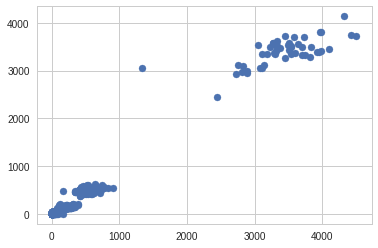

In [1252]:
plt.scatter(y_test, preds);

In [1241]:
# cond_ = (y_test > 1000) & (y_test <= 2000) & (preds > 3000)
cond_ = (y_test > 2900) & (y_test < 3100)
index_to_analyze = y_test[cond_].index

zzz = pd.concat((X_test.ix[index_to_analyze], 
                 y_test.ix[index_to_analyze]), axis=1)

preds_series = pd.Series(preds[cond_.values], index=zzz.index)

zzz = pd.concat((zzz, preds_series), axis=1)

zzz

,contact_type_Fax - Input,contact_type_Fax Acknowledgement - Input,contact_type_Installation Report - Input,contact_type_Internal Management,contact_type_Mail - Input,contact_type_Mail - Recieved,contact_type_Tweet - Input,contact_type_Visit,contact_type_Web - Input,day_of_year,weekday,mean_contact_week,max_contact_type,is_weekend,isspecialday,date,num_contacts,0
1830,0,0,0,0,0,0,0,0,0,5,0,558.604775,2991.0,0,0,2015-01-05,2991.0,536.776184
1848,0,0,0,0,0,0,0,0,0,23,4,420.737401,3975.0,0,0,2015-01-23,3032.0,3521.435303
1876,0,0,0,0,0,0,0,0,0,51,4,420.737401,3698.0,0,0,2015-02-20,3010.0,3333.246338


In [ ]:
# [120.61773046554161, 108.53284733397189, 57.428651343316155] L.B - 150.11
# [110.98862367495407, 107.24306658312813, 58.184749228326552]

# [113.29328414676097, 86.883089215522403, 83.092601814105379]
# xgb.XGBRegressor(max_depth=6, learning_rate=.009, n_estimators=300, gamma=2., colsample_bytree=.8, min_child_weight=3, seed=SEED)

In [1284]:
mask         = X_res.date < '2015/03/16'
model_res    = xgb.XGBRegressor(max_depth=6, n_estimators=300, learning_rate=.1, colsample_bytree=.8, seed=SEED)

cross_validate_resolutions(X_res.loc[mask, :], y_res.loc[mask], ['2015/01/01', '2015/02/01', '2015/03/01'], model_res, features_res[:-1])

FOLD RMSE:  36.2717732064
FOLD RMSE:  23.1612047027
FOLD RMSE:  20.0846028361


[36.271773206447833, 23.161204702663547, 20.084602836069539]

In [824]:
# [43.923743289684808, 40.875051722019684, 34.596427027205252] L.B - 150.11
# [42.968366958995659, 39.503733672365954, 34.025488412413203]

# [36.271773206447833, 23.161204702663547, 20.084602836069539]
# xgb.XGBRegressor(max_depth=6, n_estimators=300, learning_rate=.1, colsample_bytree=.8, seed=SEED)

# Full Training

In [1286]:
model.fit(X[X.columns.drop('date')], y)
model_res.fit(X_res[X_res.columns.drop('date')], y_res)

_1_Jan_median_contacts = train.loc[(X.date.dt.month == 1) & (X.date.dt.day == 1), :].groupby('contact_type')['num_contacts'].median()
_6_Jan_median_contacts = train.loc[(X.date.dt.month == 1) & (X.date.dt.day == 6), :].groupby('contact_type')['num_contacts'].median()

predict     = model.predict(Xtest[Xtest.columns.drop('date')])
predict_res = model_res.predict(Xtest_res[Xtest_res.columns.drop('date')])

indices_to_replace = Xtest[((Xtest.date.dt.month == 1) & (Xtest.date.dt.day == 1))].index
replace_preds      = contacts_test.ix[indices_to_replace]['contact_type'].map(_1_Jan_median_contacts)
predict[((Xtest.date.dt.month == 1) & (Xtest.date.dt.day == 1)).values] = replace_preds

indices_to_replace = Xtest[((Xtest.date.dt.month == 1) & (Xtest.date.dt.day == 6))].index
replace_preds      = contacts_test.ix[indices_to_replace]['contact_type'].map(_6_Jan_median_contacts)
predict[((Xtest.date.dt.month == 1) & (Xtest.date.dt.day == 6)).values] = replace_preds

In [1287]:
predict[(Xtest['contact_type_Installation Report - Input'] == 1).values] = 0.
predict[(Xtest['contact_type_Tweet - Input'] == 1).values] = 0.

In [1288]:
sub_contacts = pd.DataFrame({
  'ID': contacts_test.ID,
  'Contacts': predict,
})

sub_contacts.loc[sub_contacts.Contacts < 1, 'Contacts'] = 0.

sub_contacts.to_csv('../submissions/submissions_rule_based/Contacts.csv', index=False)

sub_resolution = pd.DataFrame({
  'ID': resolution_test.ID,
  'Resolution': predict_res,
})

sub_resolution.loc[sub_resolution.Resolution < 1, 'Resolution'] = 0.

sub_resolution.to_csv('../submissions/submissions_rule_based/Resolution.csv', index=False)

In [1289]:
sub_contacts.merge(contacts_test, left_on='ID', right_on='ID')

,Contacts_x,ID,date,contact_type,Contacts_y,quarter_mean
0,0.000000,1,2017-01-01,Mail - Recieved,NaN,5.779037
1,108.477806,2,2017-01-02,Mail - Recieved,NaN,82.558074
2,122.305870,3,2017-01-03,Mail - Recieved,NaN,103.084986
3,131.282059,4,2017-01-04,Mail - Recieved,NaN,102.753541
4,132.077271,5,2017-01-05,Mail - Recieved,NaN,103.065156
5,0.000000,6,2017-01-06,Mail - Recieved,NaN,92.228814
6,10.415906,7,2017-01-07,Mail - Recieved,NaN,14.014124
7,8.390289,8,2017-01-08,Mail - Recieved,NaN,5.838983
8,131.525818,9,2017-01-09,Mail - Recieved,NaN,82.935028
9,133.437378,10,2017-01-10,Mail - Recieved,NaN,103.542373
